In [1]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
import numpy as np
import matplotlib.pyplot as plt
import pysemp.pysemp as SEMP
import pyswarms

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
[r_STA,r_WI,r_PSP,r_SOLO] = [0.960392 ,1.016119 *0.99,0.790755,0.675801]
[alpha_STA,alpha_WI,alpha_PSP,alpha_SOLO] = np.array([-67.013 ,0,21.177, 117.397]) *np.pi/180

In [4]:
f = np.load('../../SEMPdemo/20200721/output/offset.npz')

In [5]:
t_STA = f['t_ST_A_offset']*60
freq_STA = f['f_ST_A']*1e6
t_WI = f['t_WIND_offset']*60
freq_WI = f['f_WIND']*1e6
t_PSP = f['t_PSP_offset']*60
freq_PSP = f['f_PSP']*1e6
t_SOLO = f['t_SOLO_offset']*60
freq_SOLO = f['f_SOLO']*1e6

In [6]:
# x: [t0,theta0,vs]
v_sw = 300
Min_Func = lambda x:( SEMP.Dt_STA_WI_PSP_SOLO(freq_STA,freq_WI,freq_PSP,freq_SOLO,
        t_STA,t_WI,t_PSP,t_SOLO, x[:,0],x[:,1],x[:,2],v_sw,
        alpha_STA,alpha_WI,alpha_PSP,alpha_SOLO,
        r_STA,r_WI,r_PSP,r_SOLO,
        1,1,4,16,Ne_par=2) )


In [7]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of GlobalBestPSO
optimizer = pyswarms.single.GlobalBestPSO(n_particles=100, dimensions=3,
                                    options=options,bounds=([0,-2*np.pi,1e3],[6000,2*np.pi,2e5]))

In [8]:

stats = optimizer.optimize(Min_Func, iters=300)

2023-05-02 23:01:38,655 - pyswarms.single.global_best - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|300/300, best_cost=32 
2023-05-02 23:01:46,117 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 31.963832525036413, best pos: [ 2.73135235e+03 -3.07219772e+00  4.56103990e+04]


In [9]:
f_model = np.logspace(4.5,7,30)
t_model_STA = np.zeros(f_model.shape)
t_model_WI = np.zeros(f_model.shape)
t_model_PSP = np.zeros(f_model.shape)
t_model_SOLO = np.zeros(f_model.shape)

for idx,freq in enumerate(f_model):
    t_model_PSP[idx] =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=v_sw,alpha=alpha_PSP, r_satellite_AU=r_PSP,Ne_par=2.0)
    t_model_STA[idx] =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=v_sw,alpha=alpha_STA, r_satellite_AU=r_STA,Ne_par=2.0)
    t_model_WI[idx]  =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=v_sw,alpha=alpha_WI,  r_satellite_AU=r_WI,Ne_par=2.0)
    t_model_SOLO[idx]=  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=v_sw,alpha=alpha_SOLO,r_satellite_AU=r_SOLO,Ne_par=2.0)

In [10]:
# save solution to file
#np.savez('solution.npz',f_model =f_model ,
#t_model_STA =t_model_STA ,
#t_model_WI =t_model_WI ,
#t_model_PSP =t_model_PSP ,
#t_model_SOLO =t_model_SOLO )

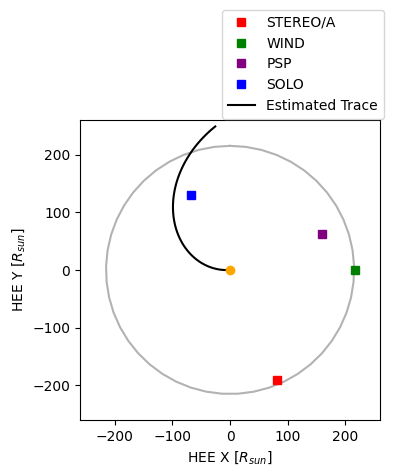

In [11]:
from matplotlib.image import NonUniformImage
fig = plt.figure(figsize=(5,6.5)) 

ax3 = fig.add_axes([1,0.3,0.6,0.6])

tmp_t = np.linspace(0,2*np.pi)
R_AU = SEMP.AU2km/SEMP.r_sun2km
r_sun2km = SEMP.r_sun2km
ax3.plot(np.sin(tmp_t)*R_AU,np.cos(tmp_t)*R_AU,'k-',alpha=0.3)
ax3.set_aspect('equal')
markWI,=ax3.plot(r_WI*np.cos(0)*R_AU,r_WI*np.sin(0)*R_AU,'s',color='green',label='WIND')
markSTA,=ax3.plot(r_STA*np.cos(alpha_STA)*R_AU,r_STA*np.sin(alpha_STA)*R_AU,'s',color='red',label='STEREO/A')
markPSP,=ax3.plot(r_PSP*np.cos(alpha_PSP)*R_AU,r_PSP*np.sin(alpha_PSP)*R_AU,'s',color='purple',label='PSP')
markSOLO,=ax3.plot(r_SOLO*np.cos(alpha_SOLO)*R_AU,r_SOLO*np.sin(alpha_SOLO)*R_AU,'s',color='blue',label='SOLO')

r = np.linspace(1,250,100)*r_sun2km
theta_spiral = SEMP.parkerSpiral(r,stats[1][1],v_sw)
markSpiral,=ax3.plot(r*np.cos(theta_spiral)/r_sun2km,r*np.sin(theta_spiral)/r_sun2km,'k',label='Estimated Trace')



ax3.plot(0,0,'o',color='orange')
ax3.set_xlim([-260,260])
ax3.set_ylim([-260,260])
ax3.set_xlabel(r'HEE X [$R_{sun}$]')
ax3.set_ylabel(r'HEE Y [$R_{sun}$]')

plt.legend(handles=[markSTA,markWI,markPSP,markSOLO, markSpiral],  bbox_to_anchor=(0.45, 1.39), loc='upper left')

#fig.savefig('20200721/combined.pdf',bbox_inches='tight')


In [83]:
stats[1][1]*180/np.pi-360

-536.0239485185887

In [84]:
stats

(31.963832525036135,
 array([ 2.73135234e+03, -3.07219746e+00,  4.56103985e+04]))

In [87]:
np.savez('spiral.npz',x_spiral= r*np.cos(theta_spiral)/r_sun2km, y_spiral = r*np.sin(theta_spiral)/r_sun2km)

In [86]:
f = np.load('spiral.npz')
x_spiral = f['x_spiral']
y_spiral = f['y_spiral']